In [1]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
print("--- Section 1: Imports and Setup ---")
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             auc, precision_recall_curve, average_precision_score, roc_auc_score)

# Other popular gradient boosting libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Create directories for saving our assets
os.makedirs('saved_models', exist_ok=True)
os.makedirs('saved_graphs', exist_ok=True)
print("Directories 'saved_models' and 'saved_graphs' are ready.\n")

--- Section 1: Imports and Setup ---
Directories 'saved_models' and 'saved_graphs' are ready.



In [2]:
# ==============================================================================
# SECTION 2: DATA LOADING & PREPROCESSING
# ==============================================================================
print("--- Section 2: Data Loading & Preprocessing ---")
# Load the datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv', index_col='id')

# Separate features (X) and target (y)
X = train_df.drop('y', axis=1)
y = train_df['y']

# Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Split data into training and validation sets for robust evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
print("Data loading and preprocessing steps are defined.\n")

--- Section 2: Data Loading & Preprocessing ---
Data loading and preprocessing steps are defined.



In [3]:
# ==============================================================================
# SECTION 3: DEFINE MODELS WITH OPTIMAL HYPERPARAMETERS
# ==============================================================================
print("--- Section 3: Define Models with Optimal Hyperparameters ---")
# This section replaces the time-consuming GridSearchCV.
# We are directly instantiating the models with the best parameters found previously.
# These are the top 4 models we will use for our ensemble.

best_params = {
    'LGBM': {
        'random_state': 42,
        'n_estimators': 150,
        'learning_rate': 0.1,
        'num_leaves': 31
    },
    'XGBoost': {
        'random_state': 42,
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': 150,
        'learning_rate': 0.1,
        'max_depth': 5
    },
    'GradientBoosting': {
        'random_state': 42,
        'n_estimators': 150,
        'learning_rate': 0.1,
        'max_depth': 5
    },
    'RandomForest': {
        'random_state': 42,
        'n_estimators': 150,
        'max_depth': 15,
        'min_samples_leaf': 5
    }
}

models = {
    'LGBM': LGBMClassifier(**best_params['LGBM']),
    'XGBoost': XGBClassifier(**best_params['XGBoost']),
    'GradientBoosting': GradientBoostingClassifier(**best_params['GradientBoosting']),
    'RandomForest': RandomForestClassifier(**best_params['RandomForest'])
}

print("Models defined with pre-tuned optimal parameters.\n")

--- Section 3: Define Models with Optimal Hyperparameters ---
Models defined with pre-tuned optimal parameters.



In [4]:
# ==============================================================================
# SECTION 4: BUILD, TRAIN, AND SAVE INDIVIDUAL MODELS
# ==============================================================================
print("--- Section 4: Build, Train, and Save Individual Models ---")
# We will now create a pipeline for each pre-configured model, train it, and save it.
trained_pipelines = {}
for name, model in models.items():
    print(f"--- Training {name} ---")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    # Save the trained pipeline
    model_filename = f"saved_models/{name}_best_model.pkl"
    joblib.dump(pipeline, model_filename)
    print(f"Saved trained model to: {model_filename}")
    
    trained_pipelines[name] = pipeline

print("\nAll individual models have been trained and saved.\n")

--- Section 4: Build, Train, and Save Individual Models ---
--- Training LGBM ---
[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289
Saved trained model to: saved_models/LGBM_best_model.pkl
--- Training XGBoost ---
Saved trained model to: saved_models/XGBoost_best_model.pkl
--- Training GradientBoosting ---
Saved trained model to: saved_models/GradientBoosting_best_model.pkl
--- Training RandomForest ---
Saved trained model to: saved_models/RandomForest_best_model.pkl

All individual mo

In [5]:
# ==============================================================================
# SECTION 5: ASSEMBLE, TRAIN, & SAVE FINAL ENSEMBLE
# ==============================================================================
print("--- Section 5: Assemble, Train, & Save Final Ensemble ---")
# We use the pipelines we just trained as estimators for the ensemble
estimators = list(trained_pipelines.items())

voting_classifier = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

# Fit the ensemble model on the training data
voting_classifier.fit(X_train, y_train)
print("Ensemble training complete.")

# Save the final ensemble model
ensemble_filename = 'saved_models/elite_ensemble_model.pkl'
joblib.dump(voting_classifier, ensemble_filename)
print(f"✅ Final ensemble model saved successfully to: {ensemble_filename}\n")

--- Section 5: Assemble, Train, & Save Final Ensemble ---
[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289
Ensemble training complete.
✅ Final ensemble model saved successfully to: saved_models/elite_ensemble_model.pkl



--- Section 6 & 7: Comprehensive Evaluation & Visualization ---
Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.97      0.96    131902
    Subscribed       0.76      0.63      0.69     18098

      accuracy                           0.93    150000
     macro avg       0.86      0.80      0.83    150000
  weighted avg       0.93      0.93      0.93    150000



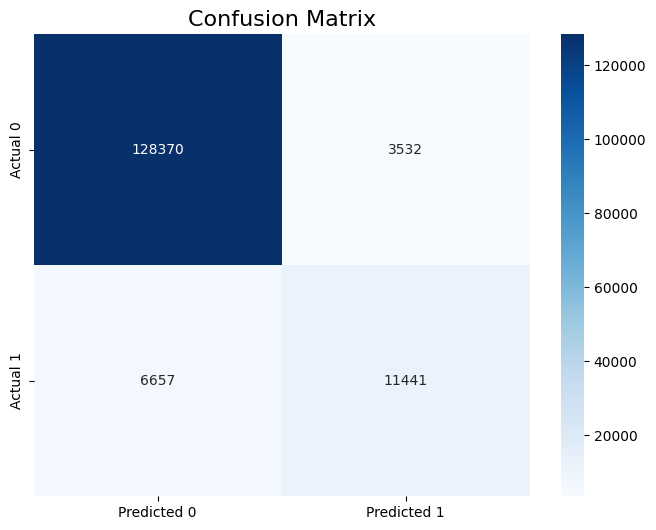

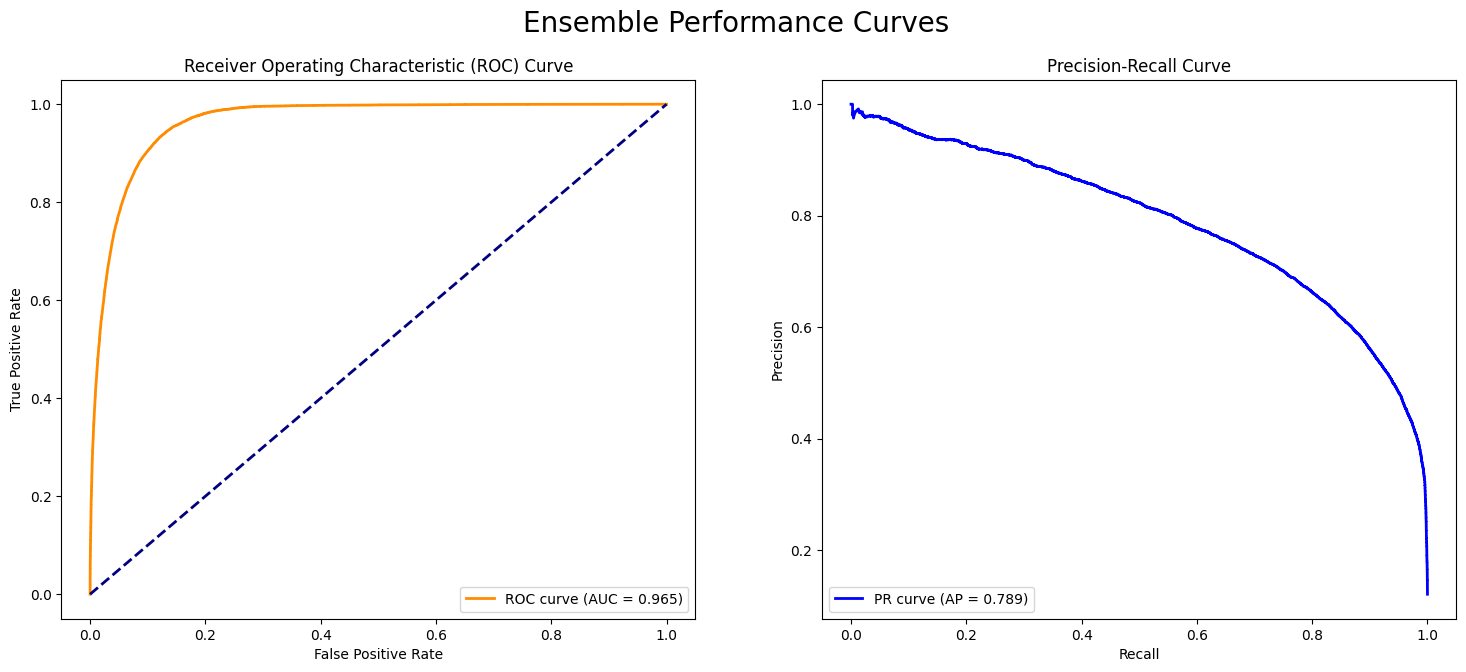


--- Feature Importance Analysis ---


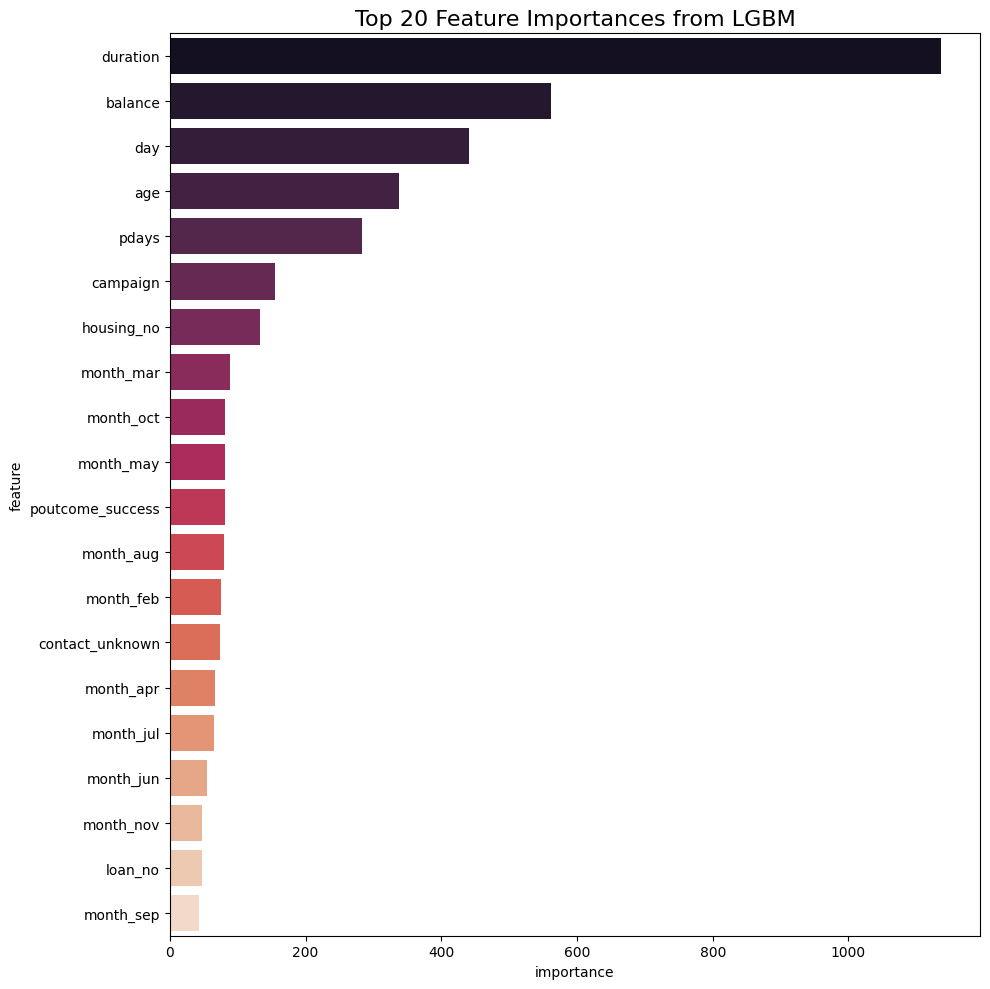

In [6]:
# ==============================================================================
# SECTION 6 & 7: EVALUATION, VISUALIZATION, AND FEATURE IMPORTANCE
# ==============================================================================
# NOTE: These sections remain the same as they operate on the trained ensemble.
print("--- Section 6 & 7: Comprehensive Evaluation & Visualization ---")
y_pred_proba = voting_classifier.predict_proba(X_val)[:, 1]
y_pred_class = voting_classifier.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred_class, target_names=['Not Subscribed', 'Subscribed']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix', fontsize=16)
plt.savefig('saved_graphs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Performance Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
roc_auc = roc_auc_score(y_val, y_pred_proba)
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
avg_precision = average_precision_score(y_val, y_pred_proba)
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left")
plt.suptitle('Ensemble Performance Curves', fontsize=20)
plt.savefig('saved_graphs/performance_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
print("\n--- Feature Importance Analysis ---")
tree_model_pipeline = trained_pipelines['LGBM'] # Use a reliable tree model
cat_features_encoded = tree_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_features_encoded)
importances = tree_model_pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='rocket')
plt.title('Top 20 Feature Importances from LGBM', fontsize=16)
plt.tight_layout()
plt.savefig('saved_graphs/feature_importance.png', dpi=300)
plt.show()
print("")

In [7]:
# ==============================================================================
# SECTION 8: GENERATE SUBMISSION FILE
# ==============================================================================
print("--- Section 8: Generate Submission File ---")
test_predictions = voting_classifier.predict_proba(test_df)[:, 1]
submission_df = pd.DataFrame({'id': test_df.index, 'y': test_predictions})
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!\n")

--- Section 8: Generate Submission File ---
Submission file 'submission.csv' created successfully!



In [8]:
# ==============================================================================
# SECTION 9: VERIFICATION OF SAVED MODEL
# ==============================================================================
print("--- Section 9: Verification of Saved Model ---")
loaded_ensemble_model = joblib.load('saved_models/elite_ensemble_model.pkl')
print("Model 'elite_ensemble_model.pkl' loaded successfully.")
print("\nPredicting on a sample of test data using the LOADED model:")
sample_predictions = loaded_ensemble_model.predict_proba(test_df.head(5))[:, 1]
verification_df = pd.DataFrame({'id': test_df.head(5).index, 'predicted_probability': sample_predictions})
print(verification_df)
print("\n✅ Verification complete. The saved model is fully operational.")
print("\n--- SCRIPT FINISHED ---")

--- Section 9: Verification of Saved Model ---
Model 'elite_ensemble_model.pkl' loaded successfully.

Predicting on a sample of test data using the LOADED model:
       id  predicted_probability
0  750000               0.009118
1  750001               0.126475
2  750002               0.004362
3  750003               0.001262
4  750004               0.037694

✅ Verification complete. The saved model is fully operational.

--- SCRIPT FINISHED ---
